In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from scipy.constants import e, hbar
from scipy.linalg import solve_sylvester

from two_coupled_qubits import ChargeQubit, Resonator

In [2]:
# Qubit and Resonator Qobj
q1 = ChargeQubit(e_c=0.23084, e_j=16.34, levels=1, n_g=0)
q2 = ChargeQubit(e_c=0.26084, e_j=16.34, levels=1, n_g=0)
r = Resonator(dim=5, w=7.50, c_r=368.440)

In [3]:
# Parameters
c_g = 1.946
beta_1 = c_g/(c_g + q1.c_s)
beta_2 = c_g/(c_g + q2.c_s)

# Operators
b = destroy(r.dim)

# Free Hamiltonian
h0 = tensor(q1.h, q2.h, r.h)

# Interacting Hamiltonian
h1r = tensor(- 1j * 2 * beta_1 * e * r.v_rms / hbar * 1e-9 * q1.number[1], qeye(q2.dim), (b - b.dag()))
h2r = tensor(qeye(q1.dim), - 1j * 2 * beta_2 * e * r.v_rms / hbar * 1e-9 * q2.number[1], (b - b.dag()))
hint = h1r + h2r

# Total Hamiltonian
h = h0 + hint

In [4]:
h

Quantum object: dims = [[3, 3, 5], [3, 3, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  6.96100175+0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j 13.9220035 +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ... 13.9220035 +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
  20.88300526+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j 27.84400701+0.j]]

In [5]:
h0

Quantum object: dims = [[3, 3, 5], [3, 3, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          6.96100175  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         13.9220035  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 13.9220035   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         20.88300526
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  27.84400701]]

In [6]:
hint

Quantum object: dims = [[3, 3, 5], [3, 3, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 ...
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]]

In [7]:
zero_matrix = tensor(0*qeye(3), 0*qeye(3), 0*qeye(5))

In [8]:
zero_matrix

Quantum object: dims = [[3, 3, 5], [3, 3, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

In [9]:
hint == zero_matrix

False

In [10]:
# Eigenvectors
_, eigenvectors_q1 = q1.h.eigenstates()
_, eigenvectors_q2 = q2.h.eigenstates()
_, eigenvectors_r = r.h.eigenstates()

# Projectors (|0><0|+|1><1|) ⊗ (|0><0|+|1><1|) ⊗ Identity
# Each tensor product is an energy eigenstate of qubits' Hamiltonian, for the resonator an identity is used
# Qubit 1 ⊗ Qubit 2 ⊗ Resonator
p = tensor(eigenvectors_q1[0] * eigenvectors_q1[0].dag() + eigenvectors_q1[1] * eigenvectors_q1[1].dag(), eigenvectors_q2[0] * eigenvectors_q2[0].dag() + eigenvectors_q2[1] * eigenvectors_q2[1].dag(), qeye(r.dim))

# S matrix from Sylvester equation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_sylvester.html)
s = Qobj(solve_sylvester(-h0.full(), h0.full(), -hint.full()))

# Effective Hamiltonian
heff = Qobj(h0.full() + 0.5 * commutator(s.full(), hint.full()))

# Reduced Hamiltonian
hred = Qobj(p * heff.full() * p)

In [11]:
p

Quantum object: dims = [[3, 3, 5], [3, 3, 5]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[0.54687211 0.         0.         ... 0.         0.         0.        ]
 [0.         0.54687211 0.         ... 0.         0.         0.        ]
 [0.         0.         0.54687211 ... 0.06785388 0.         0.        ]
 ...
 [0.         0.         0.06785388 ... 0.54687211 0.         0.        ]
 [0.         0.         0.         ... 0.         0.54687211 0.        ]
 [0.         0.         0.         ... 0.         0.         0.54687211]]

In [12]:
s

Quantum object: dims = [[45], [45]], shape = (45, 45), type = oper, isherm = False
Qobj data =
[[0.+0.00000000e+00j 0.+7.99593169e-05j 0.-3.19184637e-19j ...
  0.-6.78942941e-19j 0.+1.28346707e-18j 0.-1.25679584e-19j]
 [0.+7.99593169e-05j 0.+2.85114536e-05j 0.-4.78267133e-04j ...
  0.-3.14747759e-04j 0.-1.32894531e-18j 0.+1.07313848e-18j]
 [0.+3.19184637e-19j 0.-4.78267133e-04j 0.+1.66390433e-05j ...
  0.-7.07066429e-06j 0.-6.07170133e-05j 0.+1.03708520e-18j]
 ...
 [0.+6.78942941e-19j 0.-3.14747759e-04j 0.-7.07066429e-06j ...
  0.+1.66390433e-05j 0.-2.56687080e-04j 0.+1.62758683e-18j]
 [0.+1.28346707e-18j 0.+9.24049514e-19j 0.-6.07170133e-05j ...
  0.-2.56687080e-04j 0.-2.75344836e-05j 0.-3.43534548e-04j]
 [0.+1.25679584e-19j 0.+9.90176285e-19j 0.-1.07470021e-18j ...
  0.-1.17408240e-18j 0.-3.43534548e-04j 0.+6.58787133e-05j]]

In [13]:
heff

Quantum object: dims = [[45], [45]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          6.96100175  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         13.9220035  ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 13.9220035   0.
   0.        ]
 [ 0.          0.          0.         ...  0.         20.88300526
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  27.84400701]]

In [14]:
hred

Quantum object: dims = [[45], [45]], shape = (45, 45), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.          35.20624372   0.         ...   0.           0.
    0.        ]
 [  0.           0.          70.41248745 ... 147.77858251   0.
    0.        ]
 ...
 [  0.           0.         147.77858251 ...  70.41248745   0.
    0.        ]
 [  0.           0.           0.         ...   0.         105.61873117
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  140.82497489]]

In [15]:
# States
psi = np.empty((2, 2, r.dim), dtype=Qobj)

for i in range(2):
    for j in range(2):
        for k in range(r.dim):
            psi[i,j,k] = tensor(eigenvectors_q1[i], eigenvectors_q2[j], eigenvectors_r[k])

# Time
t_list = np.linspace(0, 20, 1000)

In [16]:
# Master Equation
result = mesolve(H=hred, rho0=psi[1,0,0], tlist=t_list, c_ops=[], e_ops=[], args={})

In [17]:
# Expected value
prob = np.empty((2, 2, r.dim), dtype=Qobj)

for i in range(2):
    for j in range(2):
        for k in range(r.dim):
            prob[i,j,k] = expect(psi[i,j,k]*psi[i,j,k].dag(), result.states)

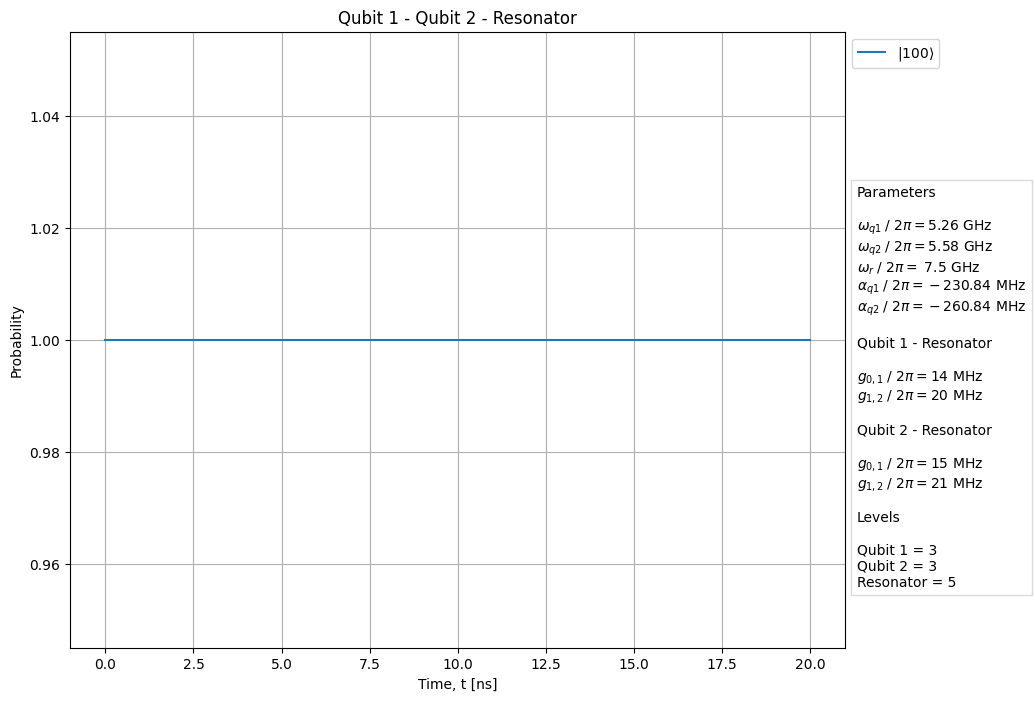

In [18]:
# Parameters
wq1 = round(q1.w / (2 * np.pi), 2)
wq2 = round(q2.w / (2 * np.pi), 2)
wr = round(r.w, 2)
alpha1 = round(q1.e_c * 1e3,2)
alpha2 = round(q2.e_c * 1e3,2)
g1_01 = round(2*beta_1*e*r.v_rms/hbar*(q1.e_j / (32 * q1.e_c)) ** (1 / 4)/(2*np.pi)*1e-6)
g1_12 = round(np.sqrt(2)*2*beta_1*e*r.v_rms/hbar*(q1.e_j / (32 * q1.e_c)) ** (1 / 4)/(2*np.pi)*1e-6)
g2_01 = round(2*beta_2*e*r.v_rms/hbar*(q2.e_j / (32 * q2.e_c)) ** (1 / 4)/(2*np.pi)*1e-6)
g2_12 = round(np.sqrt(2)*2*beta_2*e*r.v_rms/hbar*(q2.e_j / (32 * q2.e_c)) ** (1 / 4)/(2*np.pi)*1e-6)

# Plot
fig = plt.figure(figsize=(10,8))

for i in range(2):
    for j in range(2):
        for k in range(r.dim):
            if np.max(prob[i,j,k]) > 0.01:
                if (i,j,k) == (1,0,0) or (i,j,k) == (0,1,0):
                    plt.plot(t_list, prob[i,j,k], label=f"$|{i}{j}{k}\\rangle$")
                    continue
                plt.plot(t_list, prob[i,j,k], label=f"$|{i}{j}{k}\\rangle$", linestyle="--", alpha=0.5)

plt.ylabel("Probability")
plt.xlabel("Time, t [ns]")
plt.title("Qubit 1 - Qubit 2 - Resonator")
plt.legend(bbox_to_anchor=(1.00, 1.00), loc='upper left')

text = f"""Parameters

$\\omega_{{q1\,\,}}/\,\,2\\pi = ${wq1} GHz
$\\omega_{{q2\,\,}}/\,\,2\\pi = ${wq2} GHz
$\\omega_{{r\,\,}}/\,\,2\\pi = $ {wr} GHz
$\\alpha_{{q1\,\,}}/\,\,2\\pi = - ${alpha1} MHz
$\\alpha_{{q2\,\,}}/\,\,2\\pi = - ${alpha2} MHz

Qubit 1 - Resonator

$g_{{0,1\,\,}}/\,\,2\\pi = ${g1_01} MHz
$g_{{1,2\,\,}}/\,\,2\\pi = ${g1_12} MHz

Qubit 2 - Resonator

$g_{{0,1\,\,}}/\,\,2\\pi = ${g2_01} MHz
$g_{{1,2\,\,}}/\,\,2\\pi = ${g2_12} MHz

Levels

Qubit 1 = {q1.dim}
Qubit 2 = {q2.dim}
Resonator = {r.dim}"""

plt.text(1.015, 0.1, text, fontsize=10, transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', linewidth=1, alpha=0.15))

plt.grid()
plt.show()